# Transforms

Medical images are unique in that the structure of the data is quite consistent across individuals. Think about the brain - it has the same overall shape but with small nuances that cause big differences in outcomes.

We can use this to our advantage by applying random transforms - also known as data augmentation - to our images during model training in order to get more out of the images available to us. By applying random transforms in the right way, it really is like getting a completely new participant in our dataset. 

In this tutorial, you will be introduced to both fixed (i.e., preprocessing) and random (i.e., augmentation) transforms in nitrain. Applying transforms in nitrain is incredibly powerful, but our philosophy of working only on actual medical image objects, rather than arrays, may have a learning curve for some.

Let's start by creating an in-memory dataset of 3D brain images along with associated chronological age values.

In [2]:
import ants
from nitrain.datasets import MemoryDataset, fetch_data

dataset = fetch_data('example/t1-age')
print(dataset.x[:2])

[ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]
, ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]
]


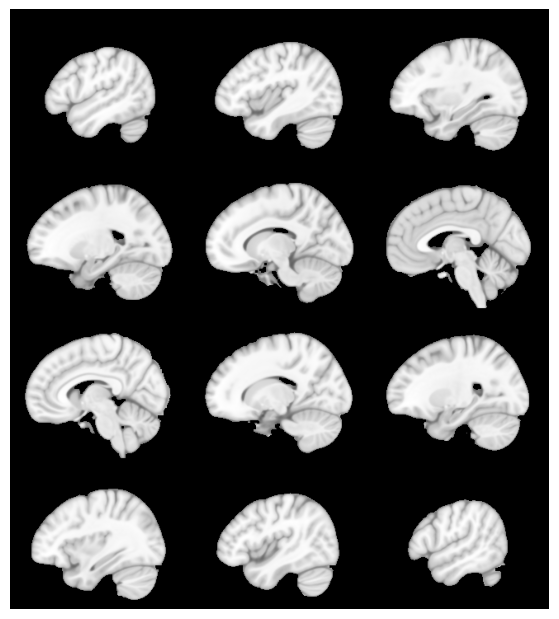

In [3]:
ants.plot(dataset.x[1])